In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy import stats

In [2]:
col_names = ['rid', 'topic', 'query', 'value', 'wid', 'batch', 'duration', 'query_mean']
dtypes = {'rid': str, 'topic': int, 'query': str, 'value': int, 'wid': str, 'batch': str, 'duration': int,
          'query_mean': float}
ranks_df = pd.read_csv('data/ranks_df_long.csv', index_col='rid', names=col_names, dtype=dtypes, header=0)
rates_df = pd.read_csv('data/ratings_df_long.csv', index_col='rid', names=col_names, dtype=dtypes, header=0)
ranks_df['value'] = ranks_df['value'].max() - ranks_df['value'] + 1

In [3]:
comb_df = pd.concat([ranks_df.assign(method='Ranking'), rates_df.assign(method='Rating')]).sort_values(
    ['topic', 'method', 'query_mean', 'value'])
comb_df['value'].clip(lower=1, inplace=True)  # clipping all ratings to start from 1

# calc std error
print(comb_df.groupby(['method', 'query'])['value'].mean().loc[('Rating', 'schizophrenia')] +
      comb_df.groupby(['method', 'query'])['value'].std().loc[('Ranking', 'schizophrenia')])

# calc ci's with seaborn
print(ranks_df.loc[ranks_df['topic'] == 213].groupby('query')['value'].apply(sns.algorithms.bootstrap).apply(
    sns.utils.ci).apply(lambda x: x[1] - x[0]))
print(rates_df.loc[rates_df['topic'] == 213].groupby('query')['value'].apply(sns.algorithms.bootstrap).apply(
    sns.utils.ci).apply(lambda x: x[1] - x[0]))

3.5652800705467813
query
carpal tunnel                     0.433333
carpal tunnel syndrome            0.377778
carpal tunnel syndrome wiki       0.455556
cts syndrome                      0.288889
what is carpal tunnel syndrome    0.388889
Name: value, dtype: float64
query
carpal tunnel                     0.465753
carpal tunnel syndrome            0.410959
carpal tunnel syndrome wiki       0.438356
cts syndrome                      0.493151
what is carpal tunnel syndrome    0.410959
Name: value, dtype: float64


In [4]:
print(
    f"Overall average time {comb_df['duration'].mean() // 60:.0f} minutes and {comb_df['duration'].mean() % 60:.0f} seconds")
print(f"with SD of {comb_df['duration'].std() // 60:.0f} minutes and {comb_df['duration'].std() % 60:.0f} seconds")

Overall average time 5 minutes and 17 seconds
with SD of 3 minutes and 52 seconds


In [5]:
print(f"Total of {comb_df['wid'].nunique()} workers submitted the filtered HITs")
print(f"Every worker did {comb_df.groupby('wid')['batch'].nunique().mean():.4g} HITs on average")

Total of 267 workers submitted the filtered HITs
Every worker did 1.94 HITs on average


In [6]:
comb_df.loc[comb_df['topic'].isin({213, 286})]

,topic,query,value,wid,batch,duration,query_mean,method
rid,,,,,,,,
48775020688,213,carpal tunnel syndrome,2,AH56J7I291XL7,red,246,1.911111,Ranking
60832753977,213,carpal tunnel syndrome,2,A4D99Y82KOLC8,red,152,1.911111,Ranking
99458784954,213,carpal tunnel syndrome,2,A13FTIHWW9GE8X,red,242,1.911111,Ranking
12734195590,213,carpal tunnel syndrome,3,A1I0DV4B4MFQCL,red,286,1.911111,Ranking
17248459875,213,carpal tunnel syndrome,3,A12R2U6TBB3OOG,red,299,1.911111,Ranking
...,...,...,...,...,...,...,...,...
893638237006,286,drug treatment schizophrenia,5,A3FKXJVH0K2E3E,green,170,4.693182,Rating
908844146155,286,drug treatment schizophrenia,5,A5NE8TWS8ZV7B,green,225,4.693182,Rating
944288367126,286,drug treatment schizophrenia,5,A1X1SOI48T1C6E,green,204,4.693182,Rating


In [7]:
unique_user_queries = pd.read_csv('data/unique_normalized_user_queries.csv', header=None, names=['qid', 'query'],
                                  index_col='query')
unique_user_queries = unique_user_queries.assign(rid=unique_user_queries.qid.str.rsplit('-', 1).str[1])
unique_user_queries

,qid,rid
query,,
carpal syndrome info,213-ranking-77160508823,77160508823
carpal tunnel,213-rating-988373623881,988373623881
carpal tunnel elderly,213-rating-619234352558,619234352558
carpal tunnel pain in elderly hands,213-rating-690392653224,690392653224
carpal tunnel pain in hands,213-rating-211885713576,211885713576
...,...,...
what can you do to prevent altitude sickness in high elevation cities,297-rating-843887168262,843887168262
what can you do to prevent high altitude sickness and what is the treatment,297-ranking-47599303745,47599303745
what is altitude sickness,297-ranking-10179138621,10179138621


In [8]:
k = 10
ndcg_df = pd.read_csv(f'data/PL2.DFR.SD-survey.ndcg@{k}', sep='\t', header=None, names=['qid', f'nDCG@{k}'],
                      index_col='qid')
canary_qids = ndcg_df.loc[ndcg_df.index.str.endswith('-0')].index
# ndcg_df.index = ndcg_df.index.str.strip()
# ndcg_df.shape
users_ndcg_df = pd.read_csv(f'data/user_queries/PL2.DFR.SD.ndcg@{k}', sep='\t', header=None, names=['qid', f'nDCG@{k}'],
                            index_col='qid')
users_ndcg_df = users_ndcg_df.loc[unique_user_queries['qid']]
users_ndcg_df

,nDCG@10
qid,
213-ranking-77160508823,0.150730
213-rating-988373623881,0.114385
213-rating-619234352558,0.092862
213-rating-690392653224,0.250808
213-rating-211885713576,0.253441
...,...
297-rating-843887168262,0.597275
297-ranking-47599303745,0.690336
297-ranking-10179138621,0.484505


In [9]:
qdf = pd.read_csv('data/QueriesSurvey.csv', header=None, names=['qid', 'query'], index_col='qid').applymap(str.strip)
qdf.index = qdf.index.str.strip()
qdf = qdf.merge(ndcg_df, left_index=True, right_index=True)
qdf['topic'] = qdf.index.str.split('-').str[0]
qdf

,query,nDCG@10,topic
qid,,,
261-2222,sore throat home remedy,0.514984,261
261-5906,sore throat,0.207764,261
261-6263,home care cough remedy,0.094559,261
261-3964,what can i use to cure a sore throat,0.360681,261
261-4857,what are some homemade remedy for a sore throat,0.305223,261
253-3763,tooth abscess treatment,0.633996,253
253-6283,abscess treatment,0.307865,253
253-3467,treatment for tooth abscess,0.620790,253
253-1388,tooth pain treatment,0.000000,253


In [10]:
ranks_sr = ranks_df.groupby(['query'])['value'].mean()
rates_sr = rates_df.groupby(['query'])['value'].mean()
rates_sr.sort_values()

query
ride in pennsylvania                               1.191781
healthy food                                       1.328767
heart and stroke foundation                        2.068182
cts syndrome                                       2.260274
george bush                                        2.297619
treatment for jaw pain                             2.342466
sore throat                                        2.476190
pest control                                       2.522727
schizophrenia                                      2.681818
hotline for bee control                            2.693182
what to do to prevent a heart attack               2.863636
heart attack first steps                           3.000000
heart attack                                       3.102273
healthy dark chocolate                             3.123288
home care cough remedy                             3.238095
tooth pain treatment                               3.246575
altitude sickness                 

In [11]:
qdf = qdf.assign(avg_rate=qdf['query'].map(rates_sr), avg_rank=qdf['query'].map(ranks_sr))
qdf_filtered = qdf.loc[~qdf.index.isin(canary_qids)].rename(
    columns={'topic': 'Topic', 'avg_rate': 'Rating', 'avg_rank': 'Ranking'})
qdf_filtered.head()
print('Pearson:')
print(qdf_filtered.corr(method='pearson').to_markdown(floatfmt='.2f'))
print(f"{stats.pearsonr(qdf_filtered['Rating'], qdf_filtered['Ranking'])[1]:.1g}")
print(f"{stats.pearsonr(qdf_filtered['Rating'], qdf_filtered['nDCG@10'])[1]:.1g}")
print(f"{stats.pearsonr(qdf_filtered['Ranking'], qdf_filtered['nDCG@10'])[1]:.1g}")

print('\nSpearman:')
print(qdf_filtered.corr(method='spearman').to_markdown(floatfmt='.2f'))
print('\nKendall:')
print(qdf_filtered.corr(method='kendall').to_markdown(floatfmt='.2f'))


Pearson:
|         |   nDCG@10 |   Rating |   Ranking |
|:--------|----------:|---------:|----------:|
| nDCG@10 |      1.00 |     0.49 |      0.50 |
| Rating  |      0.49 |     1.00 |      0.90 |
| Ranking |      0.50 |     0.90 |      1.00 |
3e-22
8e-05
6e-05

Spearman:
|         |   nDCG@10 |   Rating |   Ranking |
|:--------|----------:|---------:|----------:|
| nDCG@10 |      1.00 |     0.50 |      0.51 |
| Rating  |      0.50 |     1.00 |      0.91 |
| Ranking |      0.51 |     0.91 |      1.00 |

Kendall:
|         |   nDCG@10 |   Rating |   Ranking |
|:--------|----------:|---------:|----------:|
| nDCG@10 |      1.00 |     0.36 |      0.36 |
| Rating  |      0.36 |     1.00 |      0.76 |
| Ranking |      0.36 |     0.76 |      1.00 |


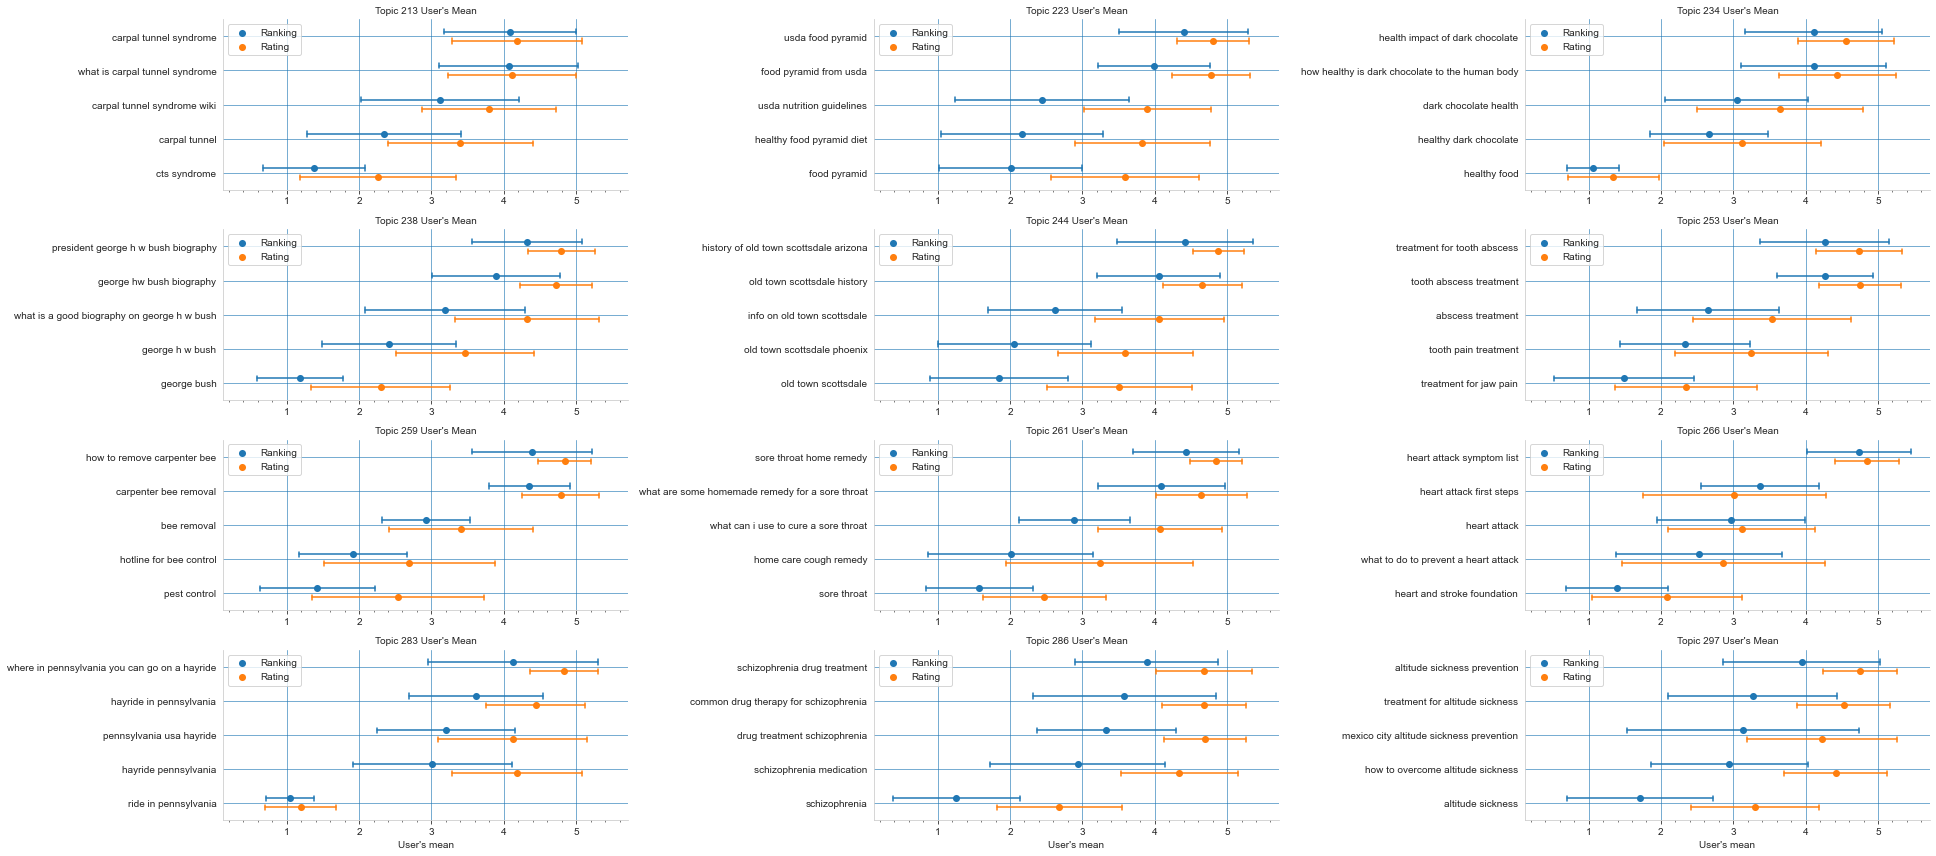

In [12]:
sns.set_style("whitegrid")

# _df = comb_df.loc[comb_df['topic'].isin({213, 223, 253, 286})]
_df = comb_df
g = sns.catplot(data=_df, x='value', y='query', hue='method', kind='point', col='topic',
                hue_order=['Ranking', 'Rating'], scale=0.8, errwidth=1.5, capsize=0.15, col_wrap=3,
                height=3, aspect=3, sharey=False, sharex=True, dodge=0.27, ci='sd', join=False, margin_titles=False,
                legend=False, legend_out=False)

for ax in g.axes.flat:
    ax.minorticks_on()
    # ax.tick_params(axis='y', which='major', left=False, pad=2)
    ax.tick_params(axis='y', which='minor', left=False)
    ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='x', which='major', bottom=True, labelbottom=True)

for ax in g.axes.flat:
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xlabel("User's mean")

g.map(plt.grid, b=True, which='major', axis='x', zorder=1, linewidth=1, ms=0, alpha=0.6)
g.map(plt.grid, b=True, which='major', axis='y', zorder=1, linewidth=1, ms=0, alpha=0.6)
# g.map(plt.grid, b=True, which='minor', axis='x', zorder=0, alpha=0.3, linewidth=0.5, ms=0)

for ax in g.axes.flat:
    ax.legend(loc='upper left')
    # ax.set_title(None)

for l in ax.lines + ax.collections:
    l.set_zorder(20)

g.set_titles("Topic {col_name} User's Mean")

plt.savefig('plots/point_mean_ci.pdf', dpi=300, bbox_inches='tight')

In [13]:
ranks_sr.corr(rates_sr, method='pearson')

0.8972401444060907

In [14]:
all_user_queries = pd.read_csv('data/all_normalized_user_queries.csv', header=None, names=['qid', 'user_query']).assign(
    topic=lambda x: x.qid.apply(lambda y: y.split('-')[0])).sort_values('qid')
all_user_queries = all_user_queries.assign(rid=all_user_queries.qid.str.rsplit('-', 1).str[1])
all_user_queries = all_user_queries.assign(method=all_user_queries.qid.str.split('-').str[1].str.capitalize())
all_user_queries = all_user_queries.assign(topic=all_user_queries.qid.str.split('-').str[0].astype(int))
# filter only the accepted queries
all_user_queries = all_user_queries.loc[all_user_queries['rid'].isin(comb_df.index)]
all_user_queries['ref_qid'] = all_user_queries['user_query'].apply(lambda x: unique_user_queries.loc[x, 'qid'])
all_user_queries[f'user_nDCG@{k}'] = all_user_queries['ref_qid'].apply(lambda x: users_ndcg_df.loc[x, f'nDCG@{k}'])
all_user_queries.set_index(['method', 'topic', 'rid'])
all_user_queries

,qid,user_query,topic,rid,method,ref_qid,user_nDCG@10
129,213-ranking-12404386894,symptoms carpal tunnel,213,12404386894,Ranking,213-ranking-12404386894,0.221163
7,213-ranking-12734195590,carpal tunnel symptoms,213,12734195590,Ranking,213-ranking-12734195590,0.213350
8,213-ranking-13250011561,carpal tunnel symptoms,213,13250011561,Ranking,213-ranking-12734195590,0.213350
137,213-ranking-14107062271,symptoms of carpal tunnel syndrome,213,14107062271,Ranking,213-ranking-14107062271,0.171151
9,213-ranking-17248459875,carpal tunnel symptoms,213,17248459875,Ranking,213-ranking-12734195590,0.213350
...,...,...,...,...,...,...,...
2068,297-rating-947212223056,altitude sickness treatment,297,947212223056,Rating,297-ranking-59064628132,0.392754
2057,297-rating-948095247335,altitude sickness remedies,297,948095247335,Rating,297-ranking-65842387797,0.358042
2183,297-rating-956482484331,treatments for altitude sickness in mexico city,297,956482484331,Rating,297-rating-956482484331,0.355933
2121,297-rating-976189905893,how to prevent altitude sickness,297,976189905893,Rating,297-ranking-11299309425,0.332475


In [15]:
comb_df = comb_df.assign(qid=comb_df['query'].map(qdf.reset_index().set_index('query')['qid']))
comb_df

,topic,query,value,wid,batch,duration,query_mean,method,qid
rid,,,,,,,,,
48775020688,213,carpal tunnel syndrome,2,AH56J7I291XL7,red,246,1.911111,Ranking,213-2264
60832753977,213,carpal tunnel syndrome,2,A4D99Y82KOLC8,red,152,1.911111,Ranking,213-2264
99458784954,213,carpal tunnel syndrome,2,A13FTIHWW9GE8X,red,242,1.911111,Ranking,213-2264
12734195590,213,carpal tunnel syndrome,3,A1I0DV4B4MFQCL,red,286,1.911111,Ranking,213-2264
17248459875,213,carpal tunnel syndrome,3,A12R2U6TBB3OOG,red,299,1.911111,Ranking,213-2264
...,...,...,...,...,...,...,...,...,...
924377032299,297,altitude sickness prevention,5,A2VUF0V7HT51Q3,blue,194,4.750000,Rating,297-9981
932014057110,297,altitude sickness prevention,5,A314XJY8V1YL12,blue,368,4.750000,Rating,297-9981
947212223056,297,altitude sickness prevention,5,A1JO6AY55FG7QU,blue,224,4.750000,Rating,297-9981


Ranking reg:
 ['slope=0.083', 'intercept=-0.031', 'rvalue=0.5', 'pvalue=5.7e-05', 'stderr=0.019']
Rating reg:
 ['slope=0.091', 'intercept=-0.13', 'rvalue=0.49', 'pvalue=8.5e-05', 'stderr=0.021']


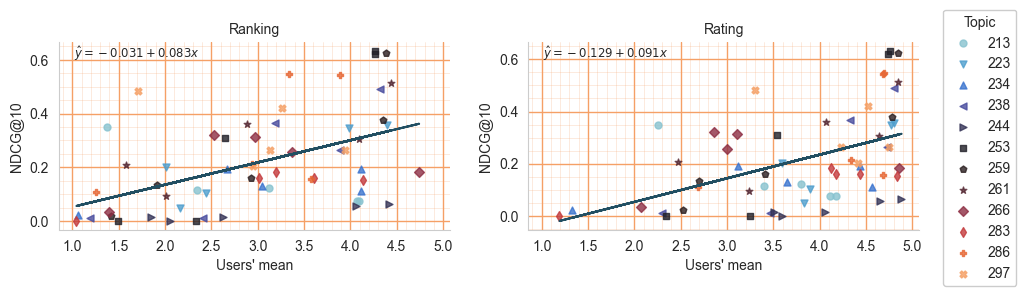

In [16]:
_df = qdf_filtered.melt(id_vars=[f'nDCG@{k}', 'Topic'], value_vars=['Ranking', 'Rating'],
                        value_name="Users' mean").sort_values('Topic').rename(columns={f'nDCG@{k}': f'NDCG@{k}'})
_rate_df = _df.loc[_df['variable'] == 'Rating']
_rank_df = _df.loc[_df['variable'] == 'Ranking']

x = "Users' mean"
y = f'NDCG@{k}'
markers = list(Line2D.filled_markers)
for m in {'8', 'h', 'H'}:
    markers.remove(m)

_col_wrap = None
g = sns.lmplot(data=_df, y=y, x=x, hue='Topic', col='variable', height=2.8, aspect=1.7, ci=None, fit_reg=False,
               markers=markers, scatter_kws=dict(s=25), palette="icefire", facet_kws=dict(sharey=False),
               col_wrap=_col_wrap, col_order=['Ranking', 'Rating'])

_rank_reg_res = stats.linregress(_rank_df[x], _rank_df[y])
rank_label = f'$ \hat{{y}}={_rank_reg_res.intercept:.3f} + {_rank_reg_res.slope:.3f}x $'

if _col_wrap is None:
    _rank_axes = g.axes[0, 0]
    _rate_axes = g.axes[0, 1]
else:
    _rank_axes = g.axes[0]
    _rate_axes = g.axes[1]

rank_line, = _rank_axes.plot(_rank_df[x], _rank_reg_res.intercept + _rank_reg_res.slope * _rank_df[x],
                             color='#224F62', label=rank_label)

_rate_reg_res = stats.linregress(_rate_df[x], _rate_df[y])
rate_label = f'$ \hat{{y}}={_rate_reg_res.intercept:.3f} + {_rate_reg_res.slope:.3f}x $'
rate_line, = _rate_axes.plot(_rate_df[x], _rate_reg_res.intercept + _rate_reg_res.slope * _rate_df[x],
                             color='#224F62', label=rate_label)

for ax in g.axes.flat:
    ax.minorticks_on()

g.map(plt.grid, b=True, which='major', axis='both', zorder=1, linewidth=1, ms=0)
g.map(plt.grid, b=True, which='minor', axis='both', zorder=0, alpha=0.3, linewidth=0.5, ms=0)

_rank_axes.text(.038, 0.92, rank_label, transform=_rank_axes.transAxes, rotation=0, size='small')
_rate_axes.text(.038, 0.92, rate_label, transform=_rate_axes.transAxes, rotation=0, size='small')

for ax in g.axes.flat:
    ax.set_ylabel(y)
for l in ax.lines + ax.collections:
    l.set_zorder(5)

g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.2)

g.legend.set_frame_on(True)
frame = g.legend.get_frame()
frame.set_facecolor('white')
frame.set_alpha(1)

plt.savefig('plots/regplot_per_task.pdf', bbox_inches='tight')

print('Ranking reg:\n', [f'{k}={v:.2g}' for v, k in zip(_rank_reg_res, _rank_reg_res._fields)])
print('Rating reg:\n', [f'{k}={v:.2g}' for v, k in zip(_rate_reg_res, _rate_reg_res._fields)])


In [17]:
# get coeffs of linear fit
_df = qdf_filtered.melt(id_vars=[f'nDCG@{k}', 'Topic'], value_vars=['Rating', 'Ranking'],
                        value_name="User's mean").sort_values('Topic')

for df in [_rate_df, _rank_df]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[x], df[y])
    print(slope)

0.09078630202419376
0.0827509456769095


In [18]:
# qdf_filtered.assign(topic=qdf_filtered.index.map(comb_df['topic']))
qdf_filtered.head()


,query,nDCG@10,Topic,Rating,Ranking
qid,,,,,
261-2222,sore throat home remedy,0.514984,261,4.845238,4.433333
261-5906,sore throat,0.207764,261,2.476190,1.577778
261-6263,home care cough remedy,0.094559,261,3.238095,2.011111
261-3964,what can i use to cure a sore throat,0.360681,261,4.071429,2.888889
261-4857,what are some homemade remedy for a sore throat,0.305223,261,4.642857,4.088889


In [19]:
qdf_filtered.melt(id_vars=[f'nDCG@{k}', 'Topic'], value_vars=['Rating', 'Ranking'], value_name="User's mean")

,nDCG@10,Topic,variable,User's mean
0,0.514984,261,Rating,4.845238
1,0.207764,261,Rating,2.476190
2,0.094559,261,Rating,3.238095
3,0.360681,261,Rating,4.071429
4,0.305223,261,Rating,4.642857
...,...,...,...,...
115,0.544897,286,Ranking,3.892473
116,0.212521,286,Ranking,2.935484
117,0.109451,286,Ranking,1.258065
118,0.155850,286,Ranking,3.580645


In [20]:
_comb_df = comb_df.reset_index().set_index(['method', 'topic', 'rid']).merge(
    all_user_queries.set_index(['method', 'topic', 'rid'])[[f'user_nDCG@{k}', 'user_query']], left_index=True,
    right_index=True)
_comb_df = _comb_df.reset_index()
comb_df = _comb_df
comb_df

,method,topic,rid,query,value,wid,batch,duration,query_mean,qid,user_nDCG@10,user_query
0,Ranking,213,12404386894,carpal tunnel syndrome,4,A39MKVROUZ1UWR,red,204,1.911111,213-2264,0.221163,symptoms carpal tunnel
1,Ranking,213,12404386894,what is carpal tunnel syndrome,5,A39MKVROUZ1UWR,red,204,1.933333,213-5606,0.221163,symptoms carpal tunnel
2,Ranking,213,12404386894,carpal tunnel syndrome wiki,3,A39MKVROUZ1UWR,red,204,2.877778,213-5173,0.221163,symptoms carpal tunnel
3,Ranking,213,12404386894,carpal tunnel,2,A39MKVROUZ1UWR,red,204,3.655556,213-7111,0.221163,symptoms carpal tunnel
4,Ranking,213,12404386894,cts syndrome,1,A39MKVROUZ1UWR,red,204,4.622222,213-2326,0.221163,symptoms carpal tunnel
...,...,...,...,...,...,...,...,...,...,...,...,...
10355,Rating,297,976386207551,altitude sickness,3,A1YH2I4Y2SYAXJ,blue,328,3.297619,297-3878,0.264538,mexico city altitude sickness prevention
10356,Rating,297,976386207551,mexico city altitude sickness prevention,5,A1YH2I4Y2SYAXJ,blue,328,4.226190,297-5173,0.264538,mexico city altitude sickness prevention
10357,Rating,297,976386207551,how to overcome altitude sickness,4,A1YH2I4Y2SYAXJ,blue,328,4.416667,297-7913,0.264538,mexico city altitude sickness prevention
10358,Rating,297,976386207551,treatment for altitude sickness,4,A1YH2I4Y2SYAXJ,blue,328,4.523810,297-9743,0.264538,mexico city altitude sickness prevention


In [21]:
# sns.regplot(data=df[['user_nDCG@10', 'selected_nDCG']], x='user_nDCG@10', y='selected_nDCG')
# _df = df

In [22]:
qpp_df = pd.read_csv('data/qpp_sd_top-50_survey.qpp', names=['qid', 'sd-60'], header=0, index_col='qid')
qpp_df.head()
qdf_filtered = qdf_filtered.assign(qpp=qpp_df)
qdf_filtered.head()

,query,nDCG@10,Topic,Rating,Ranking,qpp
qid,,,,,,
261-2222,sore throat home remedy,0.514984,261,4.845238,4.433333,2.251813
261-5906,sore throat,0.207764,261,2.476190,1.577778,0.865915
261-6263,home care cough remedy,0.094559,261,3.238095,2.011111,1.282019
261-3964,what can i use to cure a sore throat,0.360681,261,4.071429,2.888889,1.779842
261-4857,what are some homemade remedy for a sore throat,0.305223,261,4.642857,4.088889,1.702424


In [23]:
print('Pearson:')
print(qdf_filtered.corr(method='pearson').to_markdown(floatfmt='.2f'))
print('\nSpearman:')
print(qdf_filtered.corr(method='spearman').to_markdown(floatfmt='.2f'))
print('\nKendall:')
print(qdf_filtered.corr(method='kendall').to_markdown(floatfmt='.2f'))

Pearson:
|         |   nDCG@10 |   Rating |   Ranking |   qpp |
|:--------|----------:|---------:|----------:|------:|
| nDCG@10 |      1.00 |     0.49 |      0.50 |  0.46 |
| Rating  |      0.49 |     1.00 |      0.90 |  0.57 |
| Ranking |      0.50 |     0.90 |      1.00 |  0.52 |
| qpp     |      0.46 |     0.57 |      0.52 |  1.00 |

Spearman:
|         |   nDCG@10 |   Rating |   Ranking |   qpp |
|:--------|----------:|---------:|----------:|------:|
| nDCG@10 |      1.00 |     0.50 |      0.51 |  0.43 |
| Rating  |      0.50 |     1.00 |      0.91 |  0.58 |
| Ranking |      0.51 |     0.91 |      1.00 |  0.50 |
| qpp     |      0.43 |     0.58 |      0.50 |  1.00 |

Kendall:
|         |   nDCG@10 |   Rating |   Ranking |   qpp |
|:--------|----------:|---------:|----------:|------:|
| nDCG@10 |      1.00 |     0.36 |      0.36 |  0.28 |
| Rating  |      0.36 |     1.00 |      0.76 |  0.40 |
| Ranking |      0.36 |     0.76 |      1.00 |  0.34 |
| qpp     |      0.28 |     0.40 | 

In [24]:
qdf_filtered.head()

,query,nDCG@10,Topic,Rating,Ranking,qpp
qid,,,,,,
261-2222,sore throat home remedy,0.514984,261,4.845238,4.433333,2.251813
261-5906,sore throat,0.207764,261,2.476190,1.577778,0.865915
261-6263,home care cough remedy,0.094559,261,3.238095,2.011111,1.282019
261-3964,what can i use to cure a sore throat,0.360681,261,4.071429,2.888889,1.779842
261-4857,what are some homemade remedy for a sore throat,0.305223,261,4.642857,4.088889,1.702424


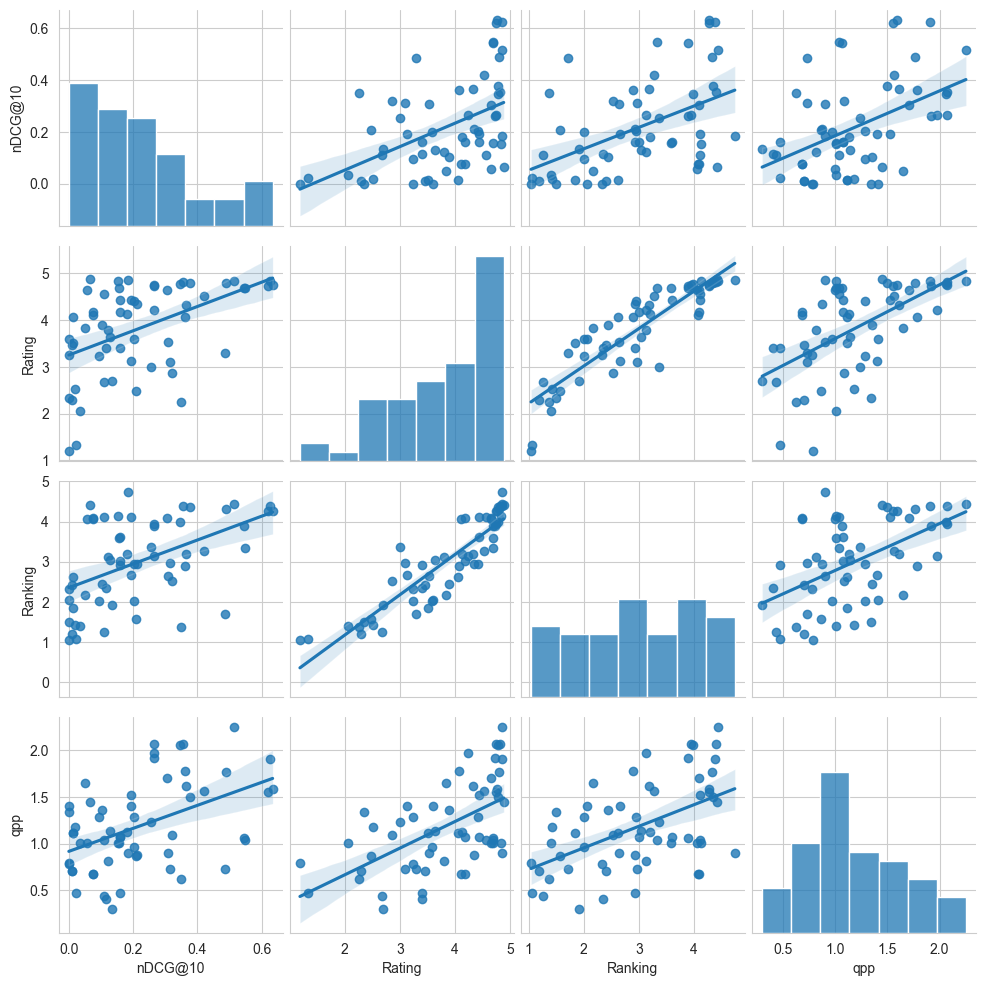

In [25]:
sns.pairplot(qdf_filtered[['nDCG@10', 'Rating', 'Ranking', 'qpp']], kind='reg')
plt.savefig('plots/pairsplot.pdf')